In [ ]:
# SpectralClustering

In [1]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
datasetBursi = vectorizer.transform( graphs )

In [1]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix
import hashlib

sparsity_factor = 0.1
samples = 1500
features = 1000
classes = 2
clusters_per_class = 2
scale_ = 1.0
data_dense, y_true = make_classification(n_samples=samples, n_features=features, n_informative=2, 
                                 n_redundant=2, n_repeated=0, n_classes=classes, 
                                 n_clusters_per_class=clusters_per_class, weights=None, flip_y=0.01,
                                 class_sep=1.0, hypercube=True, shift=0.0, scale=scale_,
                                 shuffle=True, random_state=None)
instances_list = []
features_list = []
data_list = []
# print y_true
# print hash(str(100))
# print (features/sparsity_factor)
for i, value_i in enumerate(data_dense):
    for j, value_j in enumerate(data_dense[i]):
        instances_list.append(i)
        features_list.append(hash(str(value_j)) % (features/sparsity_factor))
        data_list.append(data_dense[i][j])

data_sparse = csr_matrix((data_list, (instances_list, features_list)))
# print data_sparse

Automatically created module for IPython interactive environment
SpectralClustering :  -1.41370569477e-05
Size y:  0
Size X:  1500
Size X[1]:  9998
Labels:  [1 1 1 ..., 1 1 1]
MinHashSpectralClustering :  1.42318109718e-08
Size y:  0
Size X:  1500
Size X[1]:  9998
DBSCAN :  0.0
Size y:  0
Size X:  1500
Size X[1]:  9998
Labels:  DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='precomputed',
    min_samples=5, p=None, random_state=None)
MinHashDBSCAN : 

ValueError: labels_true and labels_pred must have same size, got 1500 and 1

/home/joachim/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


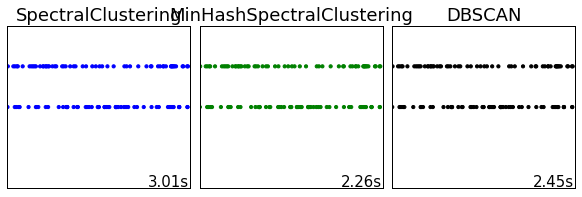

In [2]:
%matplotlib inline
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection

from neighborsMinHash.clustering import MinHashSpectralClustering 
from neighborsMinHash.clustering import MinHashDBSCAN


np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# n_samples = 1500
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
#                                       noise=.05)
# noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'SpectralClustering', 'MinHashSpectralClustering', 'DBSCAN', 'MinHashDBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

# datasets = [noisy_circles, noisy_moons, blobs, no_structure]
#for i_dataset, dataset in enumerate(datasets):
#X, y = dataset
X = data_sparse
# normalize dataset for easier parameter selection
#X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
#bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create clustering estimators
#ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=2)
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                       connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=2,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors", n_neighbors=4)
minHashSpectral = MinHashSpectralClustering(n_clusters=2,
                                      eigen_solver='arpack', n_neighbors=4)

dbscanMinHash = MinHashDBSCAN(eps=.2)
dbscan = cluster.DBSCAN(eps=.2, metric="euclidean")

affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                   preference=-200)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock", n_clusters=2,
    connectivity=connectivity)

birch = cluster.Birch(n_clusters=2)
# clustering_algorithms = [
#     two_means, affinity_propagation, spectral, minHashSpectral, ward, average_linkage,
#     dbscan, birch]
clustering_algorithms=[spectral, minHashSpectral, dbscan, dbscanMinHash]

#print "X: ", X
list_y = []
#data_projection = SparseRandomProjection(n_components=1, random_state=1)
# for i in xrange(X.shape[0]):
#     data_projection = SparseRandomProjection(n_components=1, random_state=1)
#     list_y.append([data_projection.fit_transform(X.getrow(i)).getnnz()])
# print "DataTransformed: ", list_y

data_projection = SparseRandomProjection(n_components=2, random_state=1)
data_transformed = data_projection.fit_transform(X)
#print data_transformed
x = []
y = []

for datapoint in data_transformed:
    x.append(datapoint[0,0])
    y.append(datapoint[0,1])
    
result = []
for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    t0 = time.time()
#     algorithm.fit(X)
#     t1 = time.time()
    y_pred = algorithm.fit_predict(X)
    t1 = time.time()
    y_pred = np.ravel(y_pred)
    
#     print y_pred
#     y_pred = y_pred.astype(np.int)
#     if hasattr(algorithm, 'labels_'):
#         y_pred = (algorithm.labels_).astype(np.int)
#     else:
#         y_pred = algorithm.predict(X)
    
#     print "y_pred: ", y_pred
#     print "y_true: ", y_true
    print name, ": ", adjusted_rand_score(y_true, y_pred)
#     result.append(y_pred)
    # plot
    plt.subplot(4, len(clustering_algorithms), plot_num)
    #if i_dataset == 0:
        
    plt.title(name, size=18)
#     print "X[:, 0]", X[:, 0]
#     print "X[:, 1]", X[:, 1]
#     print "colors: ", colors
#     print 'colors[y_pred]: ', colors[y_pred]
#     print "colors[y_pred].tolist(): ", colors[y_pred].tolist
    print "Size y: ", len(list_y)
    print "Size X: ", X.shape[0]
    print "Size X[1]: ", X.shape[1]
    plt.scatter(x, y_true, color=colors[y_pred].tolist(), s=10)

#     if hasattr(algorithm, 'cluster_centers_'):
#         centers = algorithm.cluster_centers_
#         center_colors = colors[:len(centers)]
#         plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()
# print y
# print y_pred
print adjusted_rand_score(y_true, y_pred)

/home/joachim/.local/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/joachim/.local/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:207: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
/home/joachim/.local/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:443: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
/home/joachim/.local/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:207: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing

Automatically created module for IPython interactive environment


/home/joachim/.local/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:443: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


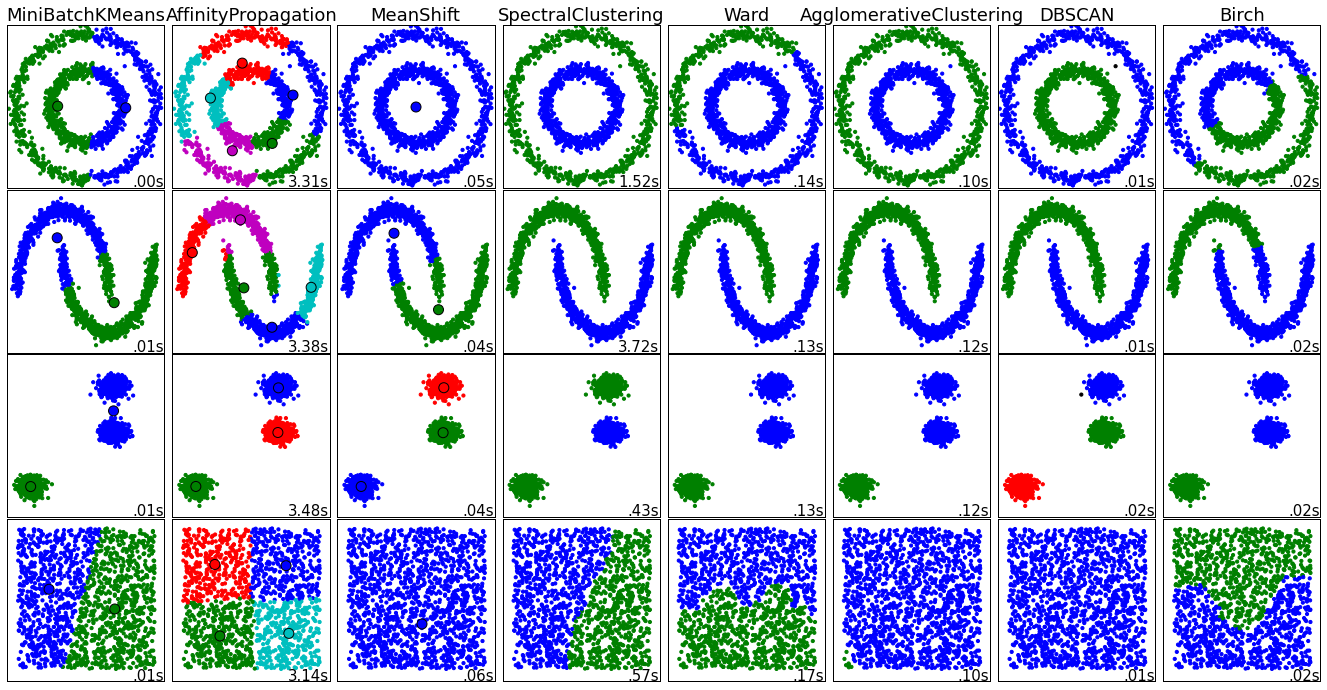

In [7]:
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=2)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                  horizontalalignment='right')
        plot_num += 1

plt.show()